<a href="https://colab.research.google.com/github/tharindatj/HandsOnMachinerLearning/blob/master/chapter2_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing liabraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load the data

In [2]:
housing = pd.read_csv('housing.csv')

Data exploration

In [3]:
print(housing.head())
print(housing.columns)
print(housing.describe())
print(housing.info())
print(housing.shape)

   longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...              452600         NEAR BAY
1    -122.22     37.86  ...              358500         NEAR BAY
2    -122.24     37.85  ...              352100         NEAR BAY
3    -122.25     37.85  ...              341300         NEAR BAY
4    -122.25     37.85  ...              342200         NEAR BAY

[5 rows x 10 columns]
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
          longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%    

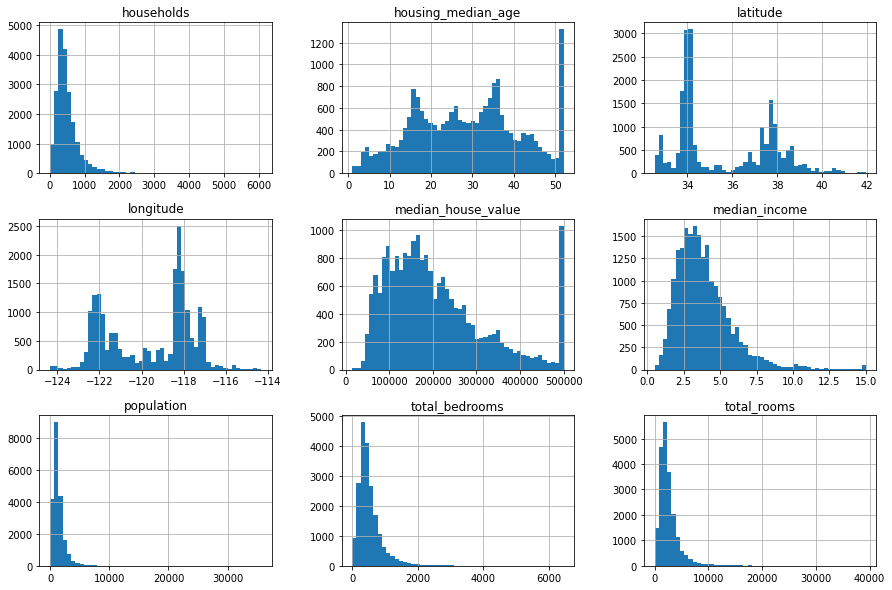

In [4]:
housing.hist(bins=50, figsize=(15,10))
plt.show()

Training  test set split

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03b106f828>]],
      dtype=object)

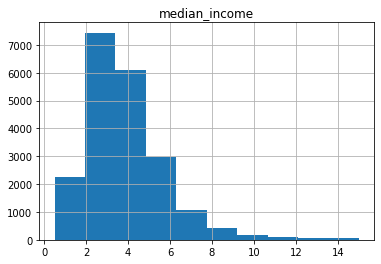

In [5]:
#median income is a key determinant of housing value
#hence train set and test set should reflect the strata and distribution of the median income
housing.hist(column='median_income')

In [6]:
#creating income category columns
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0,1.5,3,4.5,6,np.inf], labels=[1,2,3,4,5])
housing['income_cat'].value_counts()/housing['income_cat'].count()

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [7]:
#splitting test and training set based an stratas
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [8]:
a = strat_train_set['income_cat'].value_counts()/strat_train_set['income_cat'].count()
b = strat_test_set['income_cat'].value_counts()/strat_test_set['income_cat'].count()
c = housing['income_cat'].value_counts()/housing['income_cat'].count()
print('\n',a,'\n',b,'\n',c)


 3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64 
 3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64 
 3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64


In [9]:
for dfs in (strat_train_set, strat_test_set):
  dfs.drop('income_cat', axis=1, inplace=True)

In [10]:
housing = strat_train_set.copy()

Data Evaluation

In [11]:
#getting columns with missing data and identyfying columns with categorical data
missing_data_col = [col for col in housing.columns if housing[col].isnull().any()]
cat_data_col = [col for col in housing.columns if housing[col].dtype=='object']
print(f'Columns with missing data {missing_data_col},\ncolumns with catagorical data {cat_data_col}')

Columns with missing data ['total_bedrooms'],
columns with catagorical data ['ocean_proximity']


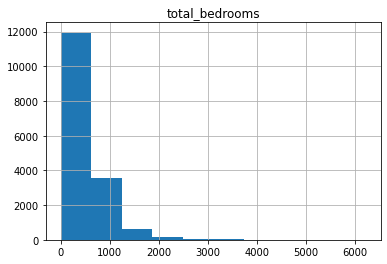

mean =  total_bedrooms    534.97389
dtype: float64
median =  total_bedrooms    433.0
dtype: float64


In [12]:
#missing data distribution
housing.hist(column=missing_data_col)
plt.show()
print('mean = ', housing[missing_data_col].mean())
print('median = ', housing[missing_data_col].median())

In [13]:
#categorical data
housing['ocean_proximity'].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [14]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

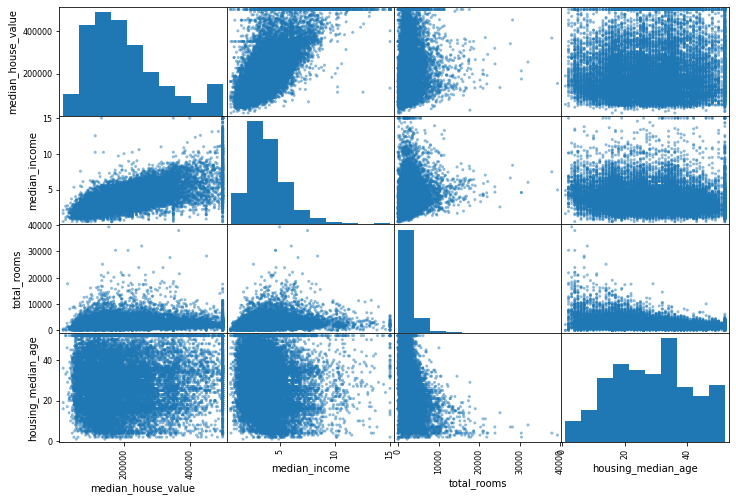

In [15]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8), diagonal='hist')
plt.show()


Spliting the data set into X, y

In [16]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

Feature additions and cleaning data

In [17]:
housing.columns
housing.values

array([[-121.89, 37.29, 38, ..., 339, 2.7042, '<1H OCEAN'],
       [-121.93, 37.05, 14, ..., 113, 6.4214, '<1H OCEAN'],
       [-117.2, 32.77, 31, ..., 462, 2.8621, 'NEAR OCEAN'],
       ...,
       [-116.4, 34.09, 9, ..., 765, 3.2723, 'INLAND'],
       [-118.01, 33.82, 31, ..., 356, 4.0625, '<1H OCEAN'],
       [-122.45, 37.77, 52, ..., 639, 3.575, 'NEAR BAY']], dtype=object)

In [135]:
#feature adtions and checking for correlations

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

from sklearn.base import BaseEstimator, TransformerMixin
new_feature=[]

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_rooms_per_household=True, add_population_per_household=True, add_bedrooms_per_room=True):
    self.add_rooms_per_household = add_rooms_per_household
    self.add_population_per_household = add_population_per_household
    self.add_bedrooms_per_room = add_bedrooms_per_room
    # self.new_feature = new_feature
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
    self.new_feature=[]
    if self.add_rooms_per_household is True and self.add_population_per_household is False and self.add_bedrooms_per_room is False:
      new_feature.append('rooms per houshold')
      return np.c_[X, rooms_per_household]
    elif self.add_rooms_per_household is True and self.add_population_per_household is True and self.add_bedrooms_per_room is False:
      new_feature.extend(('rooms per houshold','add_population_per_household'))
      return np.c_[X, rooms_per_household, population_per_household]
    elif self.add_rooms_per_household is False and self.add_population_per_household is False and self.add_bedrooms_per_room is False:
      return X
    else:
      new_feature.append('rooms per houshold','add_population_per_household','add_bedrooms_per_room')
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

attr_adder = CombinedAttributeAdder(add_rooms_per_household=True, add_population_per_household=True, add_bedrooms_per_room=False)

housing_extra_attribs = attr_adder.transform(housing.values)

In [136]:
new_feature

['rooms per houshold', 'add_population_per_household']

In [93]:
#feature adtions and checking for correlations

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

from sklearn.base import BaseEstimator, TransformerMixin
new_feature=[]

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_rooms_per_household=True, add_population_per_household=True, add_bedrooms_per_room=True, new_feature=[]):
    self.add_rooms_per_household = add_rooms_per_household
    self.add_population_per_household = add_population_per_household
    self.add_bedrooms_per_room = add_bedrooms_per_room
    self.new_feature = new_feature
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
    self.new_feature=[]
    if self.add_rooms_per_household is True and self.add_population_per_household is False and self.add_bedrooms_per_room is False:
      self.new_feature.append('rooms per houshold')
      return np.c_[X, rooms_per_household]
    elif self.add_rooms_per_household is True and self.add_population_per_household is True and self.add_bedrooms_per_room is False:
      return np.c_[X, rooms_per_household, population_per_household]
    elif self.add_rooms_per_household is False and self.add_population_per_household is False and self.add_bedrooms_per_room is False:
      return X
    else:
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

attr_adder = CombinedAttributeAdder(add_rooms_per_household=False, add_population_per_household=False, add_bedrooms_per_room=False)

housing_extra_attribs = attr_adder.transform(housing.values)

[]

In [ ]:
new_feat